In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


In [5]:
train = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv')
train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [9]:
import json


Must download from here https://mengtingwan.github.io/data/goodreads#datasets

In [51]:
# note - i had to upload this directly from the Goodreads dataset 
with open('/kaggle/input/goodreads-book-works/goodreads_book_works.json', 'r') as f:
    goodreads_data = [json.loads(line) for line in f]

# Convert the JSON data into a DataFrame
books_df = pd.DataFrame(goodreads_data)


In [11]:
books_df.head()

,books_count,reviews_count,original_publication_month,default_description_language_code,text_reviews_count,best_book_id,original_publication_year,original_title,rating_dist,default_chaptering_book_id,original_publication_day,original_language_id,ratings_count,media_type,ratings_sum,work_id
0,1,6,8,,1,5333265,1984,W. C. Fields: A Life on Film,5:1|4:1|3:1|2:0|1:0|total:3,,,,3,book,12,5400751
1,22,10162,,,741,25717,2001,Good Harbor,5:517|4:1787|3:2763|2:966|1:196|total:6229,,,,6229,book,20150,1323437
2,2,268,,,7,7327624,1987,,5:49|4:58|3:26|2:5|1:3|total:141,,,,141,book,568,8948723
3,38,89252,7,,3504,6066819,2009,Best Friends Forever,5:9152|4:16855|3:19507|2:6210|1:1549|total:53273,,14,,53273,book,185670,6243154
4,2,49,,,5,287140,1990,Runic Astrology: Starcraft and Timekeeping in ...,5:6|4:1|3:3|2:3|1:2|total:15,,,,15,book,51,278577


In [14]:
# Step 1: Select only the relevant columns from the train dataframe
train_filtered = train[['user_id', 'book_id', 'rating']].copy()

# Step 2: Ensure both columns have the same data type
# Convert book_id in train_filtered to string using .loc to avoid SettingWithCopyWarning
train_filtered.loc[:, 'book_id'] = train_filtered['book_id'].astype(str)

# Convert best_book_id in books_df to string (if it's not already)
books_df['best_book_id'] = books_df['best_book_id'].astype(str)

# Step 3: Merge the train_filtered dataframe with books_df to add the original_title
merged_df = train_filtered.merge(books_df[['best_book_id', 'original_title']],
                                 left_on='book_id', 
                                 right_on='best_book_id',
                                 how='left')

# Step 4: Drop the best_book_id column since it's not needed in the final dataframe
merged_df = merged_df.drop(columns=['best_book_id'])

# merged_df now contains user_id, book_id, rating, and original_title columns

/tmp/ipykernel_36/3232122182.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['18245960' '16981' '28684704' ... '8430896' '12275680' '17005']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_filtered.loc[:, 'book_id'] = train_filtered['book_id'].astype(str)


In [15]:
merged_df.head()

,user_id,book_id,rating,original_title
0,8842281e1d1347389f2ab93d60773d4d,18245960,5,NaN
1,8842281e1d1347389f2ab93d60773d4d,16981,3,Invisible Man
2,8842281e1d1347389f2ab93d60773d4d,28684704,3,NaN
3,8842281e1d1347389f2ab93d60773d4d,27161156,0,Hillbilly Elegy. A Memoir of a Family and Cult...
4,8842281e1d1347389f2ab93d60773d4d,25884323,4,NaN


In [16]:
df = merged_df.dropna(subset=['original_title'])

print(df.head())
print("Number of rows:", df.shape[0])

                            user_id   book_id  rating  \
1  8842281e1d1347389f2ab93d60773d4d     16981       3   
3  8842281e1d1347389f2ab93d60773d4d  27161156       0   
6  8842281e1d1347389f2ab93d60773d4d  22318578       5   
7  8842281e1d1347389f2ab93d60773d4d  24189224       0   
8  8842281e1d1347389f2ab93d60773d4d  22551730       4   

                                      original_title  
1                                      Invisible Man  
3  Hillbilly Elegy. A Memoir of a Family and Cult...  
6               Ren Sheng gatokimekuPian dukenoMo Fa  
7                                       City on Fire  
8      Dead Wake: The Last Crossing of the Lusitania  
Number of rows: 783899


In [18]:

from fastai.collab import *
from fastai.tabular.all import *

In [19]:
dls = CollabDataLoaders.from_df(df, item_name='original_title', bs=64)
dls.show_batch()

,user_id,original_title,rating
0,894b19b20edfa93f692e544ec1f93688,Eragon,4
1,05e4c96578c9efc711fdb648e7960447,Forest of a Thousand Lanterns,0
2,68118d13a6e6f38f255435e455072e74,A Little Too Hot,5
3,68ad570f1c28391c11c33849b372730e,The Wise Man's Fear,3
4,59938d44753aada135ced73983a61cdf,The Girl on the Train,2
5,71540d3c329f4f68822243d23e1d1caf,Ruined,3
6,1721679b42057884df03ae20ad6a0eb5,Dead and Gone,3
7,53573268e15260bce9b063fc31ccd3ad,La sombra del viento,5
8,68fe6465bd3d8bef6f30c3b380894040,Northern Lights,5
9,e2bcb1f4e0ada7cb360a25b56bcceffe,,5


In [24]:
n_users  = len(dls.classes['user_id'])
n_books = len(dls.classes['original_title'])

In [25]:
n_users, n_books

(12133, 13089)

In [27]:
n_factors = 5
user_factors = torch.randn(n_users, n_factors)
book_factors = torch.randn(n_books, n_factors)

In [30]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3


tensor([ 0.7810, -0.4798,  1.3427,  0.1037, -0.7534])

In [31]:
user_factors[3]


tensor([ 0.7810, -0.4798,  1.3427,  0.1037, -0.7534])

In [32]:
class DotProduct(Module):
    def __init__(self, n_users, n_books, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.book_factors = Embedding(n_books, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        books = self.book_factors(x[:,1])
        return (users * books).sum(dim=1)
     

In [33]:
model = DotProduct(n_users, n_books, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [34]:
learn.fit_one_cycle(5, 5e-3)


epoch,train_loss,valid_loss,time
0,2.052231,2.256478,02:45
1,1.765095,1.851130,02:59
2,1.471323,1.610906,02:58
3,1.241983,1.407934,02:47
4,1.237959,1.348024,02:42


In [41]:

def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [45]:

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.book_factors = create_params([n_books, n_factors])
        self.book_bias = create_params([n_books])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        books = self.book_factors[x[:,1]]
        res = (users*books).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.book_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)
     

In [46]:

model = DotProductBias(n_users, n_books, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.356740,1.434055,02:50
1,1.358013,1.420993,03:07
2,1.292121,1.371596,03:19
3,1.217462,1.321554,03:10
4,1.250922,1.303414,02:41


In [47]:

book_bias = learn.model.book_bias.squeeze()
idxs = book_bias.argsort()[:5]
[dls.classes['original_title'][i] for i in idxs]

['Fifty Shades of Grey',
 'The Claiming of Sleeping Beauty',
 'Life and Death: Twilight Reimagined',
 'The Continent',
 'No One Else Can Have You']

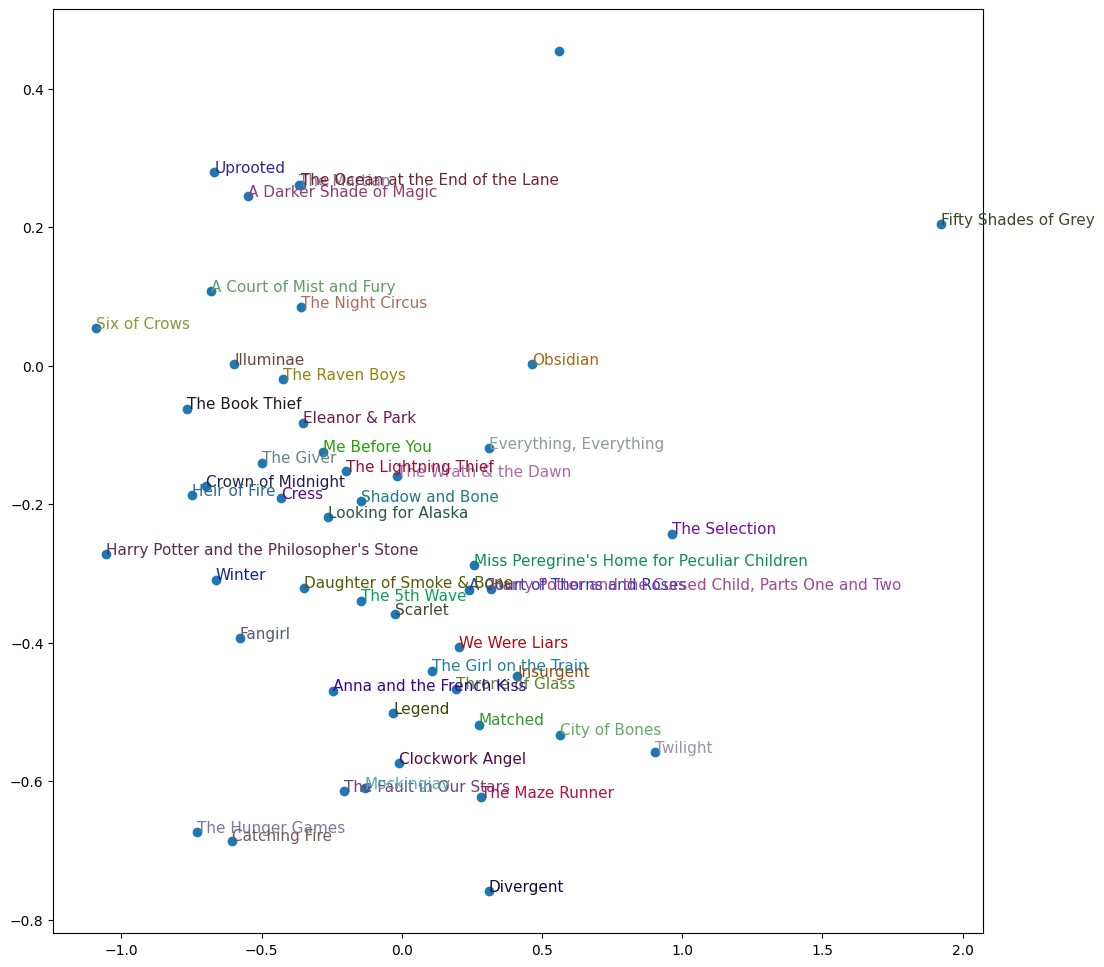

In [49]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = df.groupby('original_title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['original_title'].o2i[m] for m in top_books])
book_w = learn.model.book_factors[top_idxs].cpu().detach()
book_pca = book_w.pca(3)
fac0,fac1,fac2 = book_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()